In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

import tensorflow as tf
%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time
import math

In [ ]:
data = pd.read_csv("D:\Final Year Project\Dataset\Proposed Paper Dataset\S&P 500\gspc_final.csv")

In [5]:
data.head()

,Date,Open,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
0,03-01-2006,1248.290039,1268.800049,NaN,0.000000,NaN,NaN,NaN,89.839996,11.14,4.34,4.7,91.2
1,04-01-2006,1268.800049,1273.459961,1245.73999,0.196947,NaN,NaN,NaN,89.139999,11.37,4.22,4.7,91.2
2,05-01-2006,1273.459961,1273.479980,1245.73999,0.371553,NaN,NaN,NaN,89.330002,11.31,4.24,4.7,91.2
3,06-01-2006,1273.479980,1285.449951,1245.73999,1.030907,NaN,NaN,NaN,88.849998,11.00,4.22,4.7,91.2
4,09-01-2006,1285.449951,1290.150024,1245.73999,1.810155,NaN,NaN,NaN,89.250000,11.13,4.25,4.7,91.2


In [6]:
data.isna().sum()

Date        0
Open        0
Close       0
SAR         1
MACD        0
RSI         8
ATR        49
MFI        29
USDX        2
VIX         0
EFFR       35
UNRATE      0
UMSCENT     0
dtype: int64

In [7]:
data.drop(data.index[:49], inplace=True)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data.set_index("Date",inplace=True)
data.head()

,Open,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,,
2006-03-15,1297.479980,1303.020020,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1303.020020,1305.329956,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1305.329956,1307.250000,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1307.250000,1305.079956,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1305.079956,1297.229980,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [9]:
data = data.fillna(data.mean())
data.isna().sum()

Open       0
Close      0
SAR        0
MACD       0
RSI        0
ATR        0
MFI        0
USDX       0
VIX        0
EFFR       0
UNRATE     0
UMSCENT    0
dtype: int64

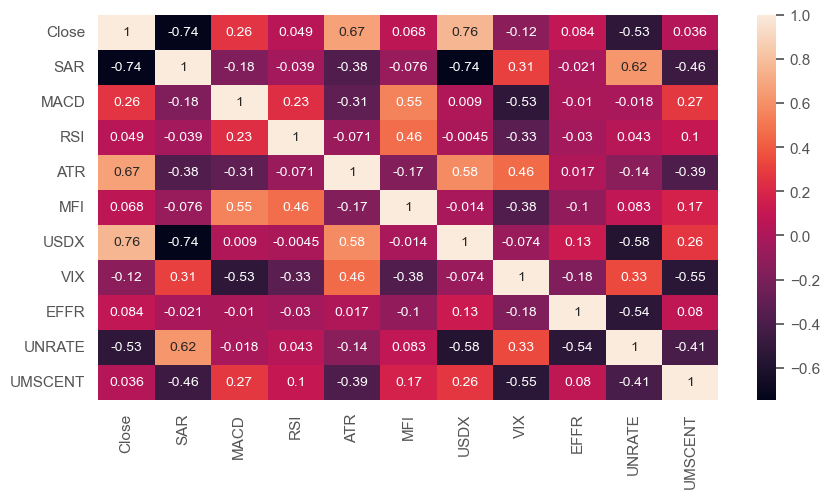

In [10]:
data = data.iloc[:, 1:]
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
plt.show()

In [11]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

data['Close']= denoise_wavelet(data.iloc[:, 0], wavelet='haar',
                                      #method='BayesShrink',
                                      method='VisuShrink',
                                      mode='soft', rescale_sigma = True)
data.head()

,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,
2006-03-15,1297.479562,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1297.479562,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1297.479562,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1297.479562,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1297.479562,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100)) #some issues with zero denominator

def calculate_scores(y_true, y_pred):
  rmse = math.sqrt(mean_squared_error(y_true, y_pred))
  #R2_score = r2_score(y_true, y_pred)
  R = np.corrcoef(y_true, y_pred)
  #mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  #dic = {'rmse':rmse, 'R2_score': R2_score, 'R':R[0,1], 'mae': mae, 'mape': mape}
  dic = {'rmse':rmse, 'R': R[0,1], 'mape': mape}
  return (dic)

def DatasetCreation(dataset, time_step = 1):  ##defining a function that gives a dataset and a time step, which then returns the input and output data
   DataX, DataY = [], []
   for i in range(len(dataset)- time_step -1):
         a = dataset[i:(i+ time_step), ]
         DataX.append(a)
         DataY.append(dataset[i + time_step, 0]) #ydata consists close price
   return np.array(DataX), np.array(DataY)

def data_split(data, split = 0.2):
  #======= creating training and test data===#
  l1   = int(len(data) * (1- split))
  l2    = len(data) - l1
  data1  = data.iloc[0:l1,:]
  data2   = data.iloc[l1:len(data),:]
  return data1, data2

def min_max_transform(data, feature_range=(0, 1)):
   scaler = MinMaxScaler(feature_range)
   return scaler.fit_transform(data)

def min_max_inverse_transform(data_scaled, min_original, max_original):
    return min_original +  data_scaled*(max_original - min_original)

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100)) #some issues with zero denominator

def rmse(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Linear Regression 

In [18]:
from sklearn.linear_model import LinearRegression

def build_linear_model():

  model = LinearRegression()
  return model

In [20]:
build_linear_model()

LinearRegression()

In [36]:
def DatasetCreationLR(data_scaled):
    X = data_scaled[:, :-1]
    Y = data_scaled[:, -1]
    return X, Y

In [45]:
def LinearRegression_model(data, test_split = 0.2):
    
    train_data, test_data = data_split(data, test_split)
    
    min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
    min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)
    
    x_train,y_train = DatasetCreationLR(train_data_scaled)
    x_test,y_test = DatasetCreationLR(test_data_scaled)
    
    model = build_linear_model()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    test_pred = min_max_inverse_transform(y_pred, min_test, max_test)
    test_true = min_max_inverse_transform(y_test, min_test, max_test)

    r = rmse(test_true, test_pred)
    print(f"RMSE: {r}")
    
    return None

In [46]:
LinearRegression_model(data, test_split = 0.2)

RMSE: 1102.7407924504469


# RNN

In [52]:
from tensorflow.keras.layers import SimpleRNN, Dense

def build_RNN(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):

      model = Sequential()

      model.add(SimpleRNN(units=layers[0], input_shape=(time_step, num_features)))

      model.add(Dense(1, activation = 'linear'))

      if optimizer == 'Adam':
        opt = optimizers.Adam(learning_rate = learning_rate)
      elif optimizer == 'Adagrad':
        opt = optimizers.Adagrad(learning_rate = learning_rate)
      elif optimizer == 'Nadam':
        opt = optimizers.Nadam(learning_rate = learning_rate)
      elif optimizer == 'Adadelta':
        opt = optimizers.Adadelta(learning_rate= learning_rate)
      elif optimizer == 'RMSprop':
        opt = optimizers.RMSprop(learning_rate= learning_rate)
      else:
        print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

      model.compile(loss='mean_squared_error', optimizer= opt)

      if verbose == 1:
        print(model.summary())
      return model

In [53]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']

build_RNN([250], 5, 10, optimizers_names[2], 0.001, 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 250)               65250     
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                                 
Total params: 65501 (255.86 KB)
Trainable params: 65501 (255.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [49]:
#========== Model hyper parameters settting ==========================#
def LSTM_model(neurons, hyper_parameters, data, time_step = 5, test_split = 0.2, epochs = 20,  num_replicates = 2):

  #====== data transformation==========#
  print("Progress: Performing data preparation steps.......\n")

  #======= creating training and test data===#

  train_data, test_data = data_split(data, test_split)

  num_features = train_data.shape[1]

  min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
  min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

  train_data_scaled  =  min_max_transform(train_data)
  test_data_scaled   = min_max_transform(test_data)


  X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
  X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

  y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train) #in original scale
  y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test) #in original scale


  print("Progress: Building and training models.......\n")

  neurons = np.array(neurons)
  #============ arrays for collecting test scores ================#
  rmse_array = np.zeros((len(neurons), num_replicates))
  #mae_array  = np.zeros((len(neurons), num_replicates))
  mape_array = np.zeros((len(neurons), num_replicates))
  #R2_array   = np.zeros((len(neurons), num_replicates))
  R_array    = np.zeros((len(neurons), num_replicates))
  elapsed_time_array = np.zeros((len(neurons), num_replicates))


  #========== array for collecting history and predictions =======#
  models_history = []
  train_predictions = []
  test_predictions  = []

  for i in range(len(neurons)):

    print("Model hyperparameters used: \n ", hyper_parameters[i])
    #========== saving history and predictions per replicate=====#
    model_history_per_replicate = []
    train_predictions_per_replicate = []
    test_predictions_per_replicate  = []

    hidden_nodes = int(neurons[i])

   # print("Program is running for %d neurons ----->\n" %np.int(neurons[i]))


    for k in range(num_replicates):

      print("Program is running for %d neurons and %d replicate ----->\n" %(hidden_nodes, k))



      layers = [hidden_nodes]


      model = build_RNN(layers, time_step, num_features, optimizer = hyper_parameters[i][0], learning_rate = hyper_parameters[i][1], verbose = 0)
      callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5)
      # This callback will stop the training when there is no improvement in
      # the loss for three consecutive epochs
      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[i][2], epochs= epochs, callbacks=[callback], verbose = 1)
      end = time.time()
      elapsed_time = end - start

      model_history_per_replicate.append(history)


      #==============Making train and test prediction in original scales ==========
      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) #in original scale
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions_per_replicate.append(train_pred)
      test_predictions_per_replicate.append(test_pred)

      #============== Calculating performance scores=========
      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)
      rmse_array[i][k] = scores['rmse']
      mape_array[i][k] =  scores['mape']
      R_array[i][k] = scores['R']
      elapsed_time_array[i][k] = elapsed_time

    models_history.append(model_history_per_replicate)
    train_predictions.append(train_predictions_per_replicate)
    test_predictions.append(test_predictions_per_replicate)

  print("Progress: Collecting outputs.......\n")

  neurons_df = pd.DataFrame(neurons)
  rmse_df = pd.DataFrame(rmse_array)
  #mae_df  = pd.DataFrame(mae_array)
  mape_df  = pd.DataFrame(mape_array)
  #R2_df   = pd.DataFrame(R2_array)
  R_df    = pd.DataFrame(R_array)
  elapsed_time_df =  pd.DataFrame(elapsed_time_array)

  train_predictions  = np.array(train_predictions)
  test_predictions   = np.array(test_predictions)

  #==== Idendifying  the best model results based on rmse ===============#
  min_index = pd.DataFrame(rmse_df.min(axis = 1)).idxmin()[0]
  min_col =   pd.DataFrame(rmse_df.min(axis = 0)).idxmin()[0]

  num_neurons_with_best_rmse = neurons_df.loc[min_index,0]

  best_rmse = rmse_df.loc[min_index, min_col]
  #mae_with_best_rmse = mae_df.loc[min_index, min_col]
  mape_with_best_rmse = mape_df.loc[min_index, min_col]
  #R2_with_best_rmse = R2_df.loc[min_index, min_col]
  R_with_best_rmse =  R_df.loc[min_index, min_col]
  elapsed_time_with_best_rmse = elapsed_time_df.loc[min_index, min_col]

  train_predictions_with_best_rmse = train_predictions[min_index][min_col]
  test_predictions_with_best_rmse = test_predictions[min_index][min_col]

  loss_with_best_rmse = models_history[min_index][min_col].history['loss']
  #val_loss_with_best_rmse = models_history[min_index][min_col].history['val_loss']

  #======= Collecting hyperparameters=============#
  hyper_parameters = { 'neurons': neurons,
                       'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                       #'validataion_split':validation_split
                        }

  #======= Collecting test scores =============#
  scores = {'neurons': neurons_df, 'rmse': rmse_df, 'mape': mape_df, 'R': R_df, 'elapsed_time': elapsed_time_df}

  #======= Collecting average test scores =============#
  avg_scores = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.mean(axis = 1),
                            'mape': mape_df.mean(axis = 1),
                            'R': R_df.mean(axis = 1),
                            'elapsed_time': elapsed_time_df.mean(axis = 1)})

 #======= Collecting average test scores =============#
  all_stds = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.std(axis = 1),
                            'mape': mape_df.std(axis = 1),
                            'R': R_df.std(axis = 1),
                            'elapsed_time': elapsed_time_df.std(axis = 1)})


 #======= Collecting average test scores =============#
  all_minimums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.min(axis = 1),
                            'mape': mape_df.min(axis = 1),
                            'R': R_df.min(axis = 1),
                            'elapsed_time': elapsed_time_df.min(axis = 1)})

  #======= Collecting average test scores =============#
  all_maximums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.max(axis = 1),
                            'mape': mape_df.max(axis = 1),
                            'R': R_df.max(axis = 1),
                            'elapsed_time': elapsed_time_df.max(axis = 1)})



  #======= Collecting the best model results =============#
  model_with_best_rmse = {  'neurons': num_neurons_with_best_rmse,
                            'replicate': min_col,
                            'rmse': best_rmse,
                            'mape': mape_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,

                         }

  datasets  =    {'data': data,
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }

  #======= Collecting all the outputs together =============#
  output_dictionary = { 'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'scores': scores,
                        'avg_scores': avg_scores,
                        'all_stds': all_stds,
                        'all_minimums': all_minimums,
                        'all_maximums': all_maximums,
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        'models_history': models_history,
                        'datasets': datasets
                       }

  print("\nBest model (neurons, replicate, rmse): ", num_neurons_with_best_rmse, min_col, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', all_stds)
  print('\nMinimums:\n', all_minimums)
  print('\nMaximums:\n', all_maximums)
  print("\nProgress: All works are done successfully, congratulations!!\n")

  return (output_dictionary)

In [54]:
neurons = np.array([25,50,100])

best_hyper_parameters = [['Adam', 0.001, 16],
                        ['Adam', 0.001, 16],
                        ['Adam', 0.001, 16]]


s2_model_output = LSTM_model(neurons, best_hyper_parameters, data, time_step = 5, test_split = 0.2,
                          epochs = 100, num_replicates = 15)

Progress: Performing data preparation steps.......

Progress: Building and training models.......

Model hyperparameters used: 
  ['Adam', 0.001, 16]
Program is running for 25 neurons and 0 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.0247
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 4/100
220/220 [==============================] - 1s 4ms/step - loss: 8.2901e-04
Epoch 5/100
220/220 [==============================] - 1s 4ms/step - loss: 6.5056e-04
Epoch 6/100
220/220 [==============================] - 1s 4ms/step - loss: 4.6997e-04
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 4.0272e-04
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3650e-04
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 2.8223e-04
Epoch 10/100
220/220 [========

220/220 [==============================] - 1s 3ms/step - loss: 5.9107e-05
Epoch 25/100
220/220 [==============================] - 1s 3ms/step - loss: 7.1133e-05
Epoch 26/100
220/220 [==============================] - 1s 3ms/step - loss: 6.6709e-05
Epoch 27/100
220/220 [==============================] - 1s 4ms/step - loss: 7.0572e-05
Epoch 28/100
220/220 [==============================] - 1s 3ms/step - loss: 6.6774e-05
Epoch 29/100
28/28 [==============================] - 0s 4ms/step
Program is running for 25 neurons and 5 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.0764
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 6/100
220/220 [=======================

220/220 [==============================] - 1s 4ms/step - loss: 5.2995e-05
Epoch 40/100
28/28 [==============================] - 0s 3ms/step
Program is running for 25 neurons and 7 replicate ----->

Epoch 1/100
220/220 [==============================] - 3s 4ms/step - loss: 0.0134
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 7.2147e-04
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 4.8967e-04
Epoch 5/100
220/220 [==============================] - 1s 4ms/step - loss: 3.8763e-04
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 2.9451e-04
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 3.0001e-04
Epoch 8/100
220/220 [==============================] - 1s 4ms/step - loss: 2.1802e-04
Epoch 9/100
220/220 [==============================] - 1s 4ms/step - loss: 1.8663e-04
Epoch 10/100
220/220 [==============

220/220 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 9.7589e-04
Epoch 7/100
220/220 [==============================] - 1s 4ms/step - loss: 8.4991e-04
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 7.1518e-04
Epoch 9/100
220/220 [==============================] - 1s 4ms/step - loss: 6.3363e-04
Epoch 10/100
220/220 [==============================] - 1s 3ms/step - loss: 5.6210e-04
Epoch 11/100
220/220 [==============================] - 1s 3ms/step - loss: 5.1221e-04
Epoch 12/100
220/220 [==============================] - 1s 4ms/step - loss: 4.5024e-04
Epoch 13/100
220/220 [==============================] - 1s 3ms/step - loss: 3.7741e-04
Epoch 14/100
220/220 [==============================] - 1s 3ms/step - loss: 3.2799e-04
Epoch 15/100
220/220 [==============================] - 1s 6ms/step -

220/220 [==============================] - 1s 4ms/step - loss: 1.5103e-04
Epoch 10/100
220/220 [==============================] - 1s 4ms/step - loss: 1.4886e-04
Epoch 11/100
220/220 [==============================] - 1s 4ms/step - loss: 1.3531e-04
Epoch 12/100
220/220 [==============================] - 1s 4ms/step - loss: 1.6539e-04
Epoch 13/100
220/220 [==============================] - 1s 4ms/step - loss: 9.9003e-05
Epoch 14/100
220/220 [==============================] - 1s 4ms/step - loss: 1.2456e-04
Epoch 15/100
220/220 [==============================] - 1s 4ms/step - loss: 1.3294e-04
Epoch 16/100
220/220 [==============================] - 1s 4ms/step - loss: 9.3447e-05
Epoch 17/100
220/220 [==============================] - 1s 3ms/step - loss: 1.5457e-04
Epoch 18/100
220/220 [==============================] - 1s 3ms/step - loss: 7.7877e-05
Epoch 19/100
220/220 [==============================] - 1s 4ms/step - loss: 8.0014e-05
Epoch 20/100
220/220 [==============================] - 

220/220 [==============================] - 1s 3ms/step - loss: 1.8488e-04
Epoch 22/100
220/220 [==============================] - 1s 3ms/step - loss: 1.3318e-04
Epoch 23/100
220/220 [==============================] - 1s 3ms/step - loss: 1.1127e-04
Epoch 24/100
220/220 [==============================] - 1s 3ms/step - loss: 1.2423e-04
Epoch 25/100
220/220 [==============================] - 1s 3ms/step - loss: 9.1833e-05
Epoch 26/100
220/220 [==============================] - 1s 3ms/step - loss: 9.8409e-05
Epoch 27/100
220/220 [==============================] - 1s 3ms/step - loss: 1.5200e-04
Epoch 28/100
220/220 [==============================] - 1s 3ms/step - loss: 1.3215e-04
Epoch 29/100
220/220 [==============================] - 1s 3ms/step - loss: 1.3899e-04
Epoch 30/100
28/28 [==============================] - 0s 4ms/step
Program is running for 50 neurons and 4 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.0193
Epoch 2/100
220/220 [===

220/220 [==============================] - 1s 3ms/step - loss: 8.3013e-05
Epoch 47/100
220/220 [==============================] - 1s 3ms/step - loss: 6.1243e-05
Epoch 48/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5746e-05
Epoch 49/100
220/220 [==============================] - 1s 4ms/step - loss: 7.1433e-05
Epoch 50/100
220/220 [==============================] - 1s 3ms/step - loss: 5.8263e-05
Epoch 51/100
220/220 [==============================] - 1s 3ms/step - loss: 8.6216e-05
Epoch 52/100
220/220 [==============================] - 1s 3ms/step - loss: 7.3522e-05
Epoch 53/100
28/28 [==============================] - 0s 3ms/step
Program is running for 50 neurons and 10 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.0384
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 6.3775e-04
Epoch 4/100
220/220 [========

220/220 [==============================] - 1s 3ms/step - loss: 8.5554e-05
Epoch 20/100
220/220 [==============================] - 1s 3ms/step - loss: 9.6772e-05
Epoch 21/100
220/220 [==============================] - 1s 3ms/step - loss: 9.8688e-05
Epoch 22/100
220/220 [==============================] - 1s 3ms/step - loss: 7.8265e-05
Epoch 23/100
220/220 [==============================] - 1s 3ms/step - loss: 9.0477e-05
Epoch 24/100
220/220 [==============================] - 1s 3ms/step - loss: 1.0158e-04
Epoch 25/100
220/220 [==============================] - 1s 3ms/step - loss: 9.9474e-05
Epoch 26/100
220/220 [==============================] - 1s 3ms/step - loss: 7.3345e-05
Epoch 27/100
220/220 [==============================] - 1s 3ms/step - loss: 8.2200e-05
Epoch 28/100
220/220 [==============================] - 1s 4ms/step - loss: 5.7928e-05
Epoch 29/100
220/220 [==============================] - 1s 3ms/step - loss: 8.6377e-05
Epoch 30/100
220/220 [==============================] - 

Epoch 1/100
220/220 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 4.8789e-04
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 3.5612e-04
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 2.1599e-04
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 2.1855e-04
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 2.0760e-04
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 2.3617e-04
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 3.1574e-04
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 1.9080e-04
Epoch 10/100
220/220 [==============================] - 1s 3ms/step - loss: 1.8486e-04
Epoch 11/100
220/220 [==============================] - 1s 3ms/step - loss: 1.6905e-04
Epoch 12/100
220/220 [==============================] - 

220/220 [==============================] - 1s 3ms/step - loss: 2.3773e-04
Epoch 17/100
220/220 [==============================] - 1s 3ms/step - loss: 1.0161e-04
Epoch 18/100
220/220 [==============================] - 1s 3ms/step - loss: 9.1696e-05
Epoch 19/100
220/220 [==============================] - 1s 4ms/step - loss: 1.4524e-04
Epoch 20/100
220/220 [==============================] - 1s 4ms/step - loss: 9.4454e-05
Epoch 21/100
220/220 [==============================] - 1s 4ms/step - loss: 9.3522e-05
Epoch 22/100
220/220 [==============================] - 1s 4ms/step - loss: 1.5452e-04
Epoch 23/100
28/28 [==============================] - 0s 3ms/step
Program is running for 100 neurons and 10 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 4ms/step - loss: 0.0080
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 5.6772e-04
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5179e-04
Epoch 4/100
220/220 [===

In [55]:
neurons = np.array([5,10,15,20])

best_hyper_parameters = [['Adam', 0.001, 16],
                        ['Adam', 0.001, 16],
                        ['Adam', 0.001, 16],
                        ['Adam', 0.001, 16]]


s2_model_output = LSTM_model(neurons, best_hyper_parameters, data, time_step = 5, test_split = 0.2,
                          epochs = 100, num_replicates = 15)

Progress: Performing data preparation steps.......

Progress: Building and training models.......

Model hyperparameters used: 
  ['Adam', 0.001, 16]
Program is running for 5 neurons and 0 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.1715
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0235
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0160
Epoch 4/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0116
Epoch 5/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0084
Epoch 6/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0061
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 8/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0030
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 10/100
220/220 [==============================] -

220/220 [==============================] - 1s 3ms/step - loss: 4.3787e-05
Epoch 47/100
220/220 [==============================] - 1s 3ms/step - loss: 4.1688e-05
Epoch 48/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9889e-05
Epoch 49/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9284e-05
Epoch 50/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9925e-05
Epoch 51/100
220/220 [==============================] - 1s 3ms/step - loss: 3.5985e-05
Epoch 52/100
220/220 [==============================] - 1s 3ms/step - loss: 4.3202e-05
Epoch 53/100
220/220 [==============================] - 1s 3ms/step - loss: 3.5537e-05
Epoch 54/100
220/220 [==============================] - 1s 3ms/step - loss: 3.4598e-05
Epoch 55/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3362e-05
Epoch 56/100
220/220 [==============================] - 1s 3ms/step - loss: 3.5878e-05
Epoch 57/100
220/220 [==============================] - 

220/220 [==============================] - 0s 2ms/step - loss: 3.4863e-05
Epoch 76/100
220/220 [==============================] - 0s 2ms/step - loss: 3.4617e-05
Epoch 77/100
28/28 [==============================] - 0s 2ms/step
Program is running for 5 neurons and 5 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 2ms/step - loss: 0.5588
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 3/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 5/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 7/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 8/100
220/220 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 9/100
220/220 [==============================] - 0s 2m

220/220 [==============================] - 1s 3ms/step - loss: 8.9496e-05
Epoch 35/100
220/220 [==============================] - 1s 3ms/step - loss: 8.2563e-05
Epoch 36/100
220/220 [==============================] - 1s 3ms/step - loss: 7.7935e-05
Epoch 37/100
220/220 [==============================] - 1s 3ms/step - loss: 7.3946e-05
Epoch 38/100
220/220 [==============================] - 1s 3ms/step - loss: 7.3250e-05
Epoch 39/100
220/220 [==============================] - 1s 3ms/step - loss: 7.6131e-05
Epoch 40/100
220/220 [==============================] - 1s 3ms/step - loss: 6.6286e-05
Epoch 41/100
220/220 [==============================] - 1s 3ms/step - loss: 6.5456e-05
Epoch 42/100
220/220 [==============================] - 1s 3ms/step - loss: 6.5154e-05
Epoch 43/100
220/220 [==============================] - 1s 3ms/step - loss: 6.1378e-05
Epoch 44/100
220/220 [==============================] - 1s 3ms/step - loss: 5.8971e-05
Epoch 45/100
220/220 [==============================] - 

Epoch 29/100
220/220 [==============================] - 1s 3ms/step - loss: 1.8317e-04
Epoch 30/100
220/220 [==============================] - 1s 3ms/step - loss: 1.7166e-04
Epoch 31/100
220/220 [==============================] - 1s 3ms/step - loss: 1.4918e-04
Epoch 32/100
220/220 [==============================] - 1s 4ms/step - loss: 1.3150e-04
Epoch 33/100
220/220 [==============================] - 1s 3ms/step - loss: 1.2680e-04
Epoch 34/100
220/220 [==============================] - 1s 3ms/step - loss: 1.1189e-04
Epoch 35/100
220/220 [==============================] - 1s 3ms/step - loss: 9.8454e-05
Epoch 36/100
220/220 [==============================] - 1s 3ms/step - loss: 9.1603e-05
Epoch 37/100
220/220 [==============================] - 1s 3ms/step - loss: 8.9577e-05
Epoch 38/100
220/220 [==============================] - 1s 3ms/step - loss: 7.9016e-05
Epoch 39/100
220/220 [==============================] - 1s 3ms/step - loss: 7.2376e-05
Epoch 40/100
220/220 [=====================

220/220 [==============================] - 1s 3ms/step - loss: 3.3386e-05
Epoch 81/100
220/220 [==============================] - 1s 3ms/step - loss: 3.2319e-05
Epoch 82/100
220/220 [==============================] - 1s 3ms/step - loss: 3.1967e-05
Epoch 83/100
28/28 [==============================] - 0s 1ms/step
Program is running for 5 neurons and 11 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 4ms/step - loss: 0.0685
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0138
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 6/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0032
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 8/100
220/220 [==============================] -

220/220 [==============================] - 1s 3ms/step - loss: 3.2186e-05
Epoch 91/100
220/220 [==============================] - 1s 3ms/step - loss: 3.6163e-05
Epoch 92/100
220/220 [==============================] - 1s 3ms/step - loss: 3.5722e-05
Epoch 93/100
220/220 [==============================] - 1s 3ms/step - loss: 3.1866e-05
Epoch 94/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3222e-05
Epoch 95/100
220/220 [==============================] - 1s 3ms/step - loss: 3.0159e-05
Epoch 96/100
220/220 [==============================] - 1s 3ms/step - loss: 3.2230e-05
Epoch 97/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3745e-05
Epoch 98/100
220/220 [==============================] - 1s 3ms/step - loss: 3.2201e-05
Epoch 99/100
220/220 [==============================] - 1s 3ms/step - loss: 3.0268e-05
Epoch 100/100
28/28 [==============================] - 0s 3ms/step
Program is running for 5 neurons and 12 replicate ----->

Epoch 1/100
220/22

220/220 [==============================] - 1s 3ms/step - loss: 4.2599e-05
Epoch 77/100
220/220 [==============================] - 1s 3ms/step - loss: 4.2294e-05
Epoch 78/100
220/220 [==============================] - 1s 3ms/step - loss: 4.3557e-05
Epoch 79/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5833e-05
Epoch 80/100
220/220 [==============================] - 1s 3ms/step - loss: 4.1204e-05
Epoch 81/100
220/220 [==============================] - 1s 3ms/step - loss: 4.2918e-05
Epoch 82/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5151e-05
Epoch 83/100
220/220 [==============================] - 1s 3ms/step - loss: 4.3746e-05
Epoch 84/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9789e-05
Epoch 85/100
220/220 [==============================] - 1s 3ms/step - loss: 4.1180e-05
Epoch 86/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9821e-05
Epoch 87/100
220/220 [==============================] - 

220/220 [==============================] - 0s 2ms/step - loss: 3.4881e-05
Epoch 73/100
220/220 [==============================] - 0s 2ms/step - loss: 3.3100e-05
Epoch 74/100
220/220 [==============================] - 0s 2ms/step - loss: 3.3327e-05
Epoch 75/100
220/220 [==============================] - 0s 2ms/step - loss: 3.8278e-05
Epoch 76/100
220/220 [==============================] - 0s 2ms/step - loss: 3.3377e-05
Epoch 77/100
220/220 [==============================] - 0s 2ms/step - loss: 3.3994e-05
Epoch 78/100
28/28 [==============================] - 0s 2ms/step
Program is running for 10 neurons and 1 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 2ms/step - loss: 0.0561
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 5/100
220/220 [==================

220/220 [==============================] - 0s 2ms/step - loss: 6.0458e-05
Epoch 25/100
220/220 [==============================] - 0s 2ms/step - loss: 5.7825e-05
Epoch 26/100
220/220 [==============================] - 0s 2ms/step - loss: 6.0153e-05
Epoch 27/100
220/220 [==============================] - 0s 2ms/step - loss: 5.2734e-05
Epoch 28/100
220/220 [==============================] - 0s 2ms/step - loss: 5.0126e-05
Epoch 29/100
220/220 [==============================] - 0s 2ms/step - loss: 5.3922e-05
Epoch 30/100
220/220 [==============================] - 0s 2ms/step - loss: 4.8843e-05
Epoch 31/100
220/220 [==============================] - 0s 2ms/step - loss: 4.8112e-05
Epoch 32/100
220/220 [==============================] - 0s 2ms/step - loss: 4.5305e-05
Epoch 33/100
220/220 [==============================] - 0s 2ms/step - loss: 4.2355e-05
Epoch 34/100
220/220 [==============================] - 0s 2ms/step - loss: 4.5877e-05
Epoch 35/100
220/220 [==============================] - 

220/220 [==============================] - 0s 2ms/step - loss: 1.0769e-04
Epoch 47/100
220/220 [==============================] - 0s 2ms/step - loss: 1.0901e-04
Epoch 48/100
220/220 [==============================] - 0s 2ms/step - loss: 1.0448e-04
Epoch 49/100
220/220 [==============================] - 0s 2ms/step - loss: 1.1123e-04
Epoch 50/100
220/220 [==============================] - 0s 2ms/step - loss: 1.0613e-04
Epoch 51/100
220/220 [==============================] - 0s 2ms/step - loss: 9.3432e-05
Epoch 52/100
220/220 [==============================] - 0s 2ms/step - loss: 9.0131e-05
Epoch 53/100
220/220 [==============================] - 0s 2ms/step - loss: 9.0854e-05
Epoch 54/100
220/220 [==============================] - 0s 2ms/step - loss: 8.8512e-05
Epoch 55/100
220/220 [==============================] - 0s 2ms/step - loss: 8.6106e-05
Epoch 56/100
220/220 [==============================] - 0s 2ms/step - loss: 9.3721e-05
Epoch 57/100
220/220 [==============================] - 

220/220 [==============================] - 1s 3ms/step - loss: 1.0719e-04
Epoch 27/100
220/220 [==============================] - 1s 3ms/step - loss: 1.0148e-04
Epoch 28/100
220/220 [==============================] - 1s 3ms/step - loss: 9.4964e-05
Epoch 29/100
220/220 [==============================] - 1s 3ms/step - loss: 8.7148e-05
Epoch 30/100
220/220 [==============================] - 1s 3ms/step - loss: 8.3059e-05
Epoch 31/100
220/220 [==============================] - 0s 2ms/step - loss: 7.4687e-05
Epoch 32/100
220/220 [==============================] - 1s 3ms/step - loss: 6.9732e-05
Epoch 33/100
220/220 [==============================] - 1s 2ms/step - loss: 7.1392e-05
Epoch 34/100
220/220 [==============================] - 0s 2ms/step - loss: 6.3491e-05
Epoch 35/100
220/220 [==============================] - 1s 3ms/step - loss: 6.0166e-05
Epoch 36/100
220/220 [==============================] - 1s 3ms/step - loss: 5.4885e-05
Epoch 37/100
220/220 [==============================] - 

220/220 [==============================] - 1s 3ms/step - loss: 6.5214e-05
Epoch 25/100
220/220 [==============================] - 1s 3ms/step - loss: 6.0844e-05
Epoch 26/100
220/220 [==============================] - 1s 3ms/step - loss: 5.9352e-05
Epoch 27/100
220/220 [==============================] - 1s 3ms/step - loss: 6.4376e-05
Epoch 28/100
220/220 [==============================] - 1s 3ms/step - loss: 5.6637e-05
Epoch 29/100
220/220 [==============================] - 1s 3ms/step - loss: 5.4094e-05
Epoch 30/100
220/220 [==============================] - 1s 3ms/step - loss: 5.2020e-05
Epoch 31/100
220/220 [==============================] - 1s 3ms/step - loss: 4.9501e-05
Epoch 32/100
220/220 [==============================] - 1s 3ms/step - loss: 4.9880e-05
Epoch 33/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5143e-05
Epoch 34/100
220/220 [==============================] - 1s 3ms/step - loss: 4.6471e-05
Epoch 35/100
220/220 [==============================] - 

Epoch 68/100
220/220 [==============================] - 1s 3ms/step - loss: 3.6213e-05
Epoch 69/100
28/28 [==============================] - 0s 3ms/step
Program is running for 10 neurons and 14 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.4583
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0331
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0131
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0099
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 10/100
220/220 [============================

220/220 [==============================] - 1s 3ms/step - loss: 4.3476e-05
Epoch 59/100
220/220 [==============================] - 1s 3ms/step - loss: 4.1945e-05
Epoch 60/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5009e-05
Epoch 61/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3370e-05
Epoch 62/100
220/220 [==============================] - 1s 3ms/step - loss: 3.8023e-05
Epoch 63/100
220/220 [==============================] - 1s 3ms/step - loss: 3.5758e-05
Epoch 64/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9533e-05
Epoch 65/100
220/220 [==============================] - 1s 3ms/step - loss: 4.7495e-05
Epoch 66/100
28/28 [==============================] - 0s 3ms/step
Program is running for 15 neurons and 2 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.0703
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 3/100
220/220 [========

220/220 [==============================] - 1s 3ms/step - loss: 3.3545e-05
Epoch 47/100
220/220 [==============================] - 1s 3ms/step - loss: 4.3565e-05
Epoch 48/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3840e-05
Epoch 49/100
220/220 [==============================] - 1s 3ms/step - loss: 3.6193e-05
Epoch 50/100
220/220 [==============================] - 1s 3ms/step - loss: 3.1327e-05
Epoch 51/100
220/220 [==============================] - 1s 3ms/step - loss: 3.0837e-05
Epoch 52/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9011e-05
Epoch 53/100
220/220 [==============================] - 1s 3ms/step - loss: 4.0835e-05
Epoch 54/100
220/220 [==============================] - 1s 4ms/step - loss: 3.4196e-05
Epoch 55/100
220/220 [==============================] - 1s 4ms/step - loss: 4.3812e-05
Epoch 56/100
28/28 [==============================] - 0s 3ms/step
Program is running for 15 neurons and 5 replicate ----->

Epoch 1/100
220/220

220/220 [==============================] - 1s 3ms/step - loss: 5.7587e-05
Epoch 58/100
220/220 [==============================] - 1s 3ms/step - loss: 6.0469e-05
Epoch 59/100
220/220 [==============================] - 1s 3ms/step - loss: 4.2859e-05
Epoch 60/100
220/220 [==============================] - 1s 3ms/step - loss: 5.1692e-05
Epoch 61/100
220/220 [==============================] - 1s 3ms/step - loss: 4.9037e-05
Epoch 62/100
220/220 [==============================] - 1s 3ms/step - loss: 5.0610e-05
Epoch 63/100
220/220 [==============================] - 1s 3ms/step - loss: 4.4819e-05
Epoch 64/100
28/28 [==============================] - 0s 4ms/step
Program is running for 15 neurons and 8 replicate ----->

Epoch 1/100
220/220 [==============================] - 2s 3ms/step - loss: 0.0323
Epoch 2/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 4/100
220/220 [=============

220/220 [==============================] - 1s 3ms/step - loss: 2.3308e-04
Epoch 10/100
220/220 [==============================] - 1s 3ms/step - loss: 2.1385e-04
Epoch 11/100
220/220 [==============================] - 1s 3ms/step - loss: 1.8335e-04
Epoch 12/100
220/220 [==============================] - 1s 3ms/step - loss: 1.8239e-04
Epoch 13/100
220/220 [==============================] - 1s 3ms/step - loss: 1.5152e-04
Epoch 14/100
220/220 [==============================] - 1s 3ms/step - loss: 1.4358e-04
Epoch 15/100
220/220 [==============================] - 1s 3ms/step - loss: 1.2582e-04
Epoch 16/100
220/220 [==============================] - 1s 3ms/step - loss: 1.2918e-04
Epoch 17/100
220/220 [==============================] - 1s 3ms/step - loss: 1.1820e-04
Epoch 18/100
220/220 [==============================] - 1s 3ms/step - loss: 1.0024e-04
Epoch 19/100
220/220 [==============================] - 1s 3ms/step - loss: 9.2326e-05
Epoch 20/100
220/220 [==============================] - 

Epoch 45/100
220/220 [==============================] - 1s 3ms/step - loss: 5.5722e-05
Epoch 46/100
220/220 [==============================] - 1s 3ms/step - loss: 5.9187e-05
Epoch 47/100
220/220 [==============================] - 1s 3ms/step - loss: 5.5533e-05
Epoch 48/100
220/220 [==============================] - 1s 3ms/step - loss: 5.4190e-05
Epoch 49/100
220/220 [==============================] - 1s 3ms/step - loss: 5.2640e-05
Epoch 50/100
220/220 [==============================] - 1s 3ms/step - loss: 4.9944e-05
Epoch 51/100
220/220 [==============================] - 1s 3ms/step - loss: 4.4488e-05
Epoch 52/100
220/220 [==============================] - 1s 3ms/step - loss: 5.1913e-05
Epoch 53/100
220/220 [==============================] - 1s 3ms/step - loss: 4.2277e-05
Epoch 54/100
220/220 [==============================] - 1s 3ms/step - loss: 4.5475e-05
Epoch 55/100
220/220 [==============================] - 1s 3ms/step - loss: 4.4608e-05
Epoch 56/100
220/220 [=====================

220/220 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 9.2322e-04
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 6.8940e-04
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 5.6920e-04
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 4.6490e-04
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 3.9633e-04
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 3.3752e-04
Epoch 10/100
220/220 [==============================] - 1s 3ms/step - loss: 3.1808e-04
Epoch 11/100
220/220 [==============================] - 1s 3ms/step - loss: 2.7735e-04
Epoch 12/100
220/220 [==============================] - 1s 3ms/step - loss: 2.2744e-04
Epoch 13/100
220/220 [==============================] - 1s 3ms/step - loss: 2.2001e-04
Epoch 14/100
220/220 [==============================] - 1s 3ms/ste

220/220 [==============================] - 1s 3ms/step - loss: 8.4675e-05
Epoch 32/100
220/220 [==============================] - 1s 3ms/step - loss: 8.3188e-05
Epoch 33/100
220/220 [==============================] - 1s 3ms/step - loss: 6.3499e-05
Epoch 34/100
220/220 [==============================] - 1s 3ms/step - loss: 6.5411e-05
Epoch 35/100
220/220 [==============================] - 1s 3ms/step - loss: 6.3537e-05
Epoch 36/100
220/220 [==============================] - 1s 3ms/step - loss: 7.7338e-05
Epoch 37/100
220/220 [==============================] - 1s 3ms/step - loss: 6.1246e-05
Epoch 38/100
220/220 [==============================] - 1s 3ms/step - loss: 6.6246e-05
Epoch 39/100
220/220 [==============================] - 1s 3ms/step - loss: 5.2870e-05
Epoch 40/100
220/220 [==============================] - 1s 3ms/step - loss: 6.1681e-05
Epoch 41/100
220/220 [==============================] - 1s 3ms/step - loss: 5.3408e-05
Epoch 42/100
220/220 [==============================] - 

220/220 [==============================] - 1s 3ms/step - loss: 5.8803e-05
Epoch 38/100
220/220 [==============================] - 1s 3ms/step - loss: 4.9780e-05
Epoch 39/100
220/220 [==============================] - 1s 3ms/step - loss: 6.3098e-05
Epoch 40/100
220/220 [==============================] - 1s 3ms/step - loss: 5.7220e-05
Epoch 41/100
220/220 [==============================] - 1s 3ms/step - loss: 4.8302e-05
Epoch 42/100
220/220 [==============================] - 1s 3ms/step - loss: 5.3727e-05
Epoch 43/100
220/220 [==============================] - 1s 3ms/step - loss: 6.7022e-05
Epoch 44/100
220/220 [==============================] - 1s 3ms/step - loss: 5.0412e-05
Epoch 45/100
220/220 [==============================] - 1s 3ms/step - loss: 4.2663e-05
Epoch 46/100
220/220 [==============================] - 1s 3ms/step - loss: 4.4123e-05
Epoch 47/100
220/220 [==============================] - 1s 3ms/step - loss: 4.7638e-05
Epoch 48/100
220/220 [==============================] - 

220/220 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 8.4021e-04
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 6.3740e-04
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 5.2918e-04
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 4.4688e-04
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 3.4996e-04
Epoch 10/100
220/220 [==============================] - 1s 3ms/step - loss: 3.0619e-04
Epoch 11/100
220/220 [==============================] - 1s 3ms/step - loss: 3.1946e-04
Epoch 12/100
220/220 [==============================] - 1s 3ms/step - loss: 2.4866e-04
Epoch 13/100
220/220 [==============================] - 1s 3ms/step - loss:

220/220 [==============================] - 1s 3ms/step - loss: 1.0229e-04
Epoch 34/100
220/220 [==============================] - 1s 3ms/step - loss: 1.1599e-04
Epoch 35/100
220/220 [==============================] - 1s 3ms/step - loss: 1.0230e-04
Epoch 36/100
220/220 [==============================] - 1s 3ms/step - loss: 8.7007e-05
Epoch 37/100
220/220 [==============================] - 1s 3ms/step - loss: 9.0339e-05
Epoch 38/100
220/220 [==============================] - 1s 3ms/step - loss: 1.0232e-04
Epoch 39/100
220/220 [==============================] - 1s 3ms/step - loss: 8.4556e-05
Epoch 40/100
220/220 [==============================] - 1s 3ms/step - loss: 7.7066e-05
Epoch 41/100
220/220 [==============================] - 1s 3ms/step - loss: 7.8826e-05
Epoch 42/100
220/220 [==============================] - 1s 3ms/step - loss: 8.0521e-05
Epoch 43/100
220/220 [==============================] - 1s 3ms/step - loss: 8.7143e-05
Epoch 44/100
220/220 [==============================] - 

# Bi-LSTM

In [ ]:
# epoch - 100, hidden layers - 2 - 64 units , dense - 2 with 16 and 1 unit

model = Sequential()


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()




In [20]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

def build_BiLSTM(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):

      model = Sequential()

      model.add(Bidirectional(LSTM(units=layers[0], return_sequences=True), input_shape=(time_step, num_features)))
      model.add(Bidirectional(LSTM(units=layers[0])))

      model.add(Dense(units=16))
      model.add(Dense(units=1, activation='linear'))


      if optimizer == 'Adam':
        opt = optimizers.Adam(learning_rate = learning_rate)
      elif optimizer == 'Adagrad':
        opt = optimizers.Adagrad(learning_rate = learning_rate)
      elif optimizer == 'Nadam':
        opt = optimizers.Nadam(learning_rate = learning_rate)
      elif optimizer == 'Adadelta':
        opt = optimizers.Adadelta(learning_rate= learning_rate)
      elif optimizer == 'RMSprop':
        opt = optimizers.RMSprop(learning_rate= learning_rate)
      else:
        print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

      model.compile(loss='mean_squared_error', optimizer= opt)

      if verbose == 1:
        print(model.summary())
      return model

In [21]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']

build_BiLSTM([250], 5, 10, optimizers_names[2], 0.001, 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 5, 500)            522000    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 500)               1502000   
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                8016      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2032033 (7.75 MB)
Trainable params: 2032033 (7.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [22]:
#========== Model hyper parameters settting ==========================#
def LSTM_model(neurons, hyper_parameters, data, time_step = 5, test_split = 0.2, epochs = 20,  num_replicates = 2):

  #====== data transformation==========#
  print("Progress: Performing data preparation steps.......\n")

  #======= creating training and test data===#

  train_data, test_data = data_split(data, test_split)

  num_features = train_data.shape[1]

  min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
  min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

  train_data_scaled  =  min_max_transform(train_data)
  test_data_scaled   = min_max_transform(test_data)


  X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
  X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

  y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train) #in original scale
  y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test) #in original scale


  print("Progress: Building and training models.......\n")

  neurons = np.array(neurons)
  #============ arrays for collecting test scores ================#
  rmse_array = np.zeros((len(neurons), num_replicates))
  #mae_array  = np.zeros((len(neurons), num_replicates))
  mape_array = np.zeros((len(neurons), num_replicates))
  #R2_array   = np.zeros((len(neurons), num_replicates))
  R_array    = np.zeros((len(neurons), num_replicates))
  elapsed_time_array = np.zeros((len(neurons), num_replicates))


  #========== array for collecting history and predictions =======#
  models_history = []
  train_predictions = []
  test_predictions  = []

  for i in range(len(neurons)):

    print("Model hyperparameters used: \n ", hyper_parameters[i])
    #========== saving history and predictions per replicate=====#
    model_history_per_replicate = []
    train_predictions_per_replicate = []
    test_predictions_per_replicate  = []

    hidden_nodes = int(neurons[i])

   # print("Program is running for %d neurons ----->\n" %np.int(neurons[i]))


    for k in range(num_replicates):

      print("Program is running for %d neurons and %d replicate ----->\n" %(hidden_nodes, k))



      layers = [hidden_nodes]


      model = build_BiLSTM(layers, time_step, num_features, optimizer = hyper_parameters[i][0], learning_rate = hyper_parameters[i][1], verbose = 0)
      callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5)
      # This callback will stop the training when there is no improvement in
      # the loss for three consecutive epochs
      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[i][2], epochs= epochs, callbacks=[callback], verbose = 1)
      end = time.time()
      elapsed_time = end - start

      model_history_per_replicate.append(history)


      #==============Making train and test prediction in original scales ==========
      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) #in original scale
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions_per_replicate.append(train_pred)
      test_predictions_per_replicate.append(test_pred)

      #============== Calculating performance scores=========
      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)
      rmse_array[i][k] = scores['rmse']
      mape_array[i][k] =  scores['mape']
      R_array[i][k] = scores['R']
      elapsed_time_array[i][k] = elapsed_time

    models_history.append(model_history_per_replicate)
    train_predictions.append(train_predictions_per_replicate)
    test_predictions.append(test_predictions_per_replicate)

  print("Progress: Collecting outputs.......\n")

  neurons_df = pd.DataFrame(neurons)
  rmse_df = pd.DataFrame(rmse_array)
  #mae_df  = pd.DataFrame(mae_array)
  mape_df  = pd.DataFrame(mape_array)
  #R2_df   = pd.DataFrame(R2_array)
  R_df    = pd.DataFrame(R_array)
  elapsed_time_df =  pd.DataFrame(elapsed_time_array)

  train_predictions  = np.array(train_predictions)
  test_predictions   = np.array(test_predictions)

  #==== Idendifying  the best model results based on rmse ===============#
  min_index = pd.DataFrame(rmse_df.min(axis = 1)).idxmin()[0]
  min_col =   pd.DataFrame(rmse_df.min(axis = 0)).idxmin()[0]

  num_neurons_with_best_rmse = neurons_df.loc[min_index,0]

  best_rmse = rmse_df.loc[min_index, min_col]
  #mae_with_best_rmse = mae_df.loc[min_index, min_col]
  mape_with_best_rmse = mape_df.loc[min_index, min_col]
  #R2_with_best_rmse = R2_df.loc[min_index, min_col]
  R_with_best_rmse =  R_df.loc[min_index, min_col]
  elapsed_time_with_best_rmse = elapsed_time_df.loc[min_index, min_col]

  train_predictions_with_best_rmse = train_predictions[min_index][min_col]
  test_predictions_with_best_rmse = test_predictions[min_index][min_col]

  loss_with_best_rmse = models_history[min_index][min_col].history['loss']
  #val_loss_with_best_rmse = models_history[min_index][min_col].history['val_loss']

  #======= Collecting hyperparameters=============#
  hyper_parameters = { 'neurons': neurons,
                       'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                       #'validataion_split':validation_split
                        }

  #======= Collecting test scores =============#
  scores = {'neurons': neurons_df, 'rmse': rmse_df, 'mape': mape_df, 'R': R_df, 'elapsed_time': elapsed_time_df}

  #======= Collecting average test scores =============#
  avg_scores = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.mean(axis = 1),
                            'mape': mape_df.mean(axis = 1),
                            'R': R_df.mean(axis = 1),
                            'elapsed_time': elapsed_time_df.mean(axis = 1)})

 #======= Collecting average test scores =============#
  all_stds = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.std(axis = 1),
                            'mape': mape_df.std(axis = 1),
                            'R': R_df.std(axis = 1),
                            'elapsed_time': elapsed_time_df.std(axis = 1)})


 #======= Collecting average test scores =============#
  all_minimums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.min(axis = 1),
                            'mape': mape_df.min(axis = 1),
                            'R': R_df.min(axis = 1),
                            'elapsed_time': elapsed_time_df.min(axis = 1)})

  #======= Collecting average test scores =============#
  all_maximums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.max(axis = 1),
                            'mape': mape_df.max(axis = 1),
                            'R': R_df.max(axis = 1),
                            'elapsed_time': elapsed_time_df.max(axis = 1)})



  #======= Collecting the best model results =============#
  model_with_best_rmse = {  'neurons': num_neurons_with_best_rmse,
                            'replicate': min_col,
                            'rmse': best_rmse,
                            'mape': mape_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,

                         }

  datasets  =    {'data': data,
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }

  #======= Collecting all the outputs together =============#
  output_dictionary = { 'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'scores': scores,
                        'avg_scores': avg_scores,
                        'all_stds': all_stds,
                        'all_minimums': all_minimums,
                        'all_maximums': all_maximums,
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        'models_history': models_history,
                        'datasets': datasets
                       }

  print("\nBest model (neurons, replicate, rmse): ", num_neurons_with_best_rmse, min_col, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', all_stds)
  print('\nMinimums:\n', all_minimums)
  print('\nMaximums:\n', all_maximums)
  print("\nProgress: All works are done successfully, congratulations!!\n")

  return (output_dictionary)

In [23]:
neurons = np.array([64])

best_hyper_parameters = [['Adam', 0.001, 16]]


s2_model_output = LSTM_model(neurons, best_hyper_parameters, data, time_step = 5, test_split = 0.2,
                          epochs = 100, num_replicates = 15)

Progress: Performing data preparation steps.......

Progress: Building and training models.......

Model hyperparameters used: 
  ['Adam', 0.001, 16]
Program is running for 64 neurons and 0 replicate ----->

Epoch 1/100

220/220 [==============================] - 13s 12ms/step - loss: 0.0043
Epoch 2/100
220/220 [==============================] - 3s 12ms/step - loss: 1.4114e-04
Epoch 3/100
220/220 [==============================] - 3s 12ms/step - loss: 9.5221e-05
Epoch 4/100
220/220 [==============================] - 3s 12ms/step - loss: 7.9881e-05
Epoch 5/100
220/220 [==============================] - 3s 12ms/step - loss: 8.2686e-05
Epoch 6/100
220/220 [==============================] - 3s 12ms/step - loss: 1.1280e-04
Epoch 7/100
220/220 [==============================] - 3s 12ms/step - loss: 8.1045e-05
Epoch 8/100
220/220 [==============================] - 3s 12ms/step - loss: 9.0333e-05
Epoch 9/100
28/28 [==============================] - 0s 8ms/step
Program is running for 64 neurons

Epoch 6/100
220/220 [==============================] - 3s 12ms/step - loss: 1.0848e-04
Epoch 7/100
220/220 [==============================] - 3s 12ms/step - loss: 1.0162e-04
Epoch 8/100
28/28 [==============================] - 0s 8ms/step
Program is running for 64 neurons and 7 replicate ----->

Epoch 1/100
220/220 [==============================] - 13s 12ms/step - loss: 0.0041
Epoch 2/100
220/220 [==============================] - 3s 12ms/step - loss: 1.2262e-04
Epoch 3/100
220/220 [==============================] - 2s 11ms/step - loss: 8.6732e-05
Epoch 4/100
220/220 [==============================] - 2s 11ms/step - loss: 8.8417e-05
Epoch 5/100
220/220 [==============================] - 3s 12ms/step - loss: 9.6791e-05
Epoch 6/100
220/220 [==============================] - 3s 12ms/step - loss: 8.0478e-05
Epoch 7/100
220/220 [==============================] - 3s 12ms/step - loss: 1.0352e-04
Epoch 8/100
220/220 [==============================] - 3s 12ms/step - loss: 1.0718e-04
Epoch 9/10

# Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
models_data = pd.read_excel("D:\Final Year Project\Results\VariousModelResultsRMSE.xlsx")

In [21]:
models_data.head()

,Technique,Dataset,RMSE,Unnamed: 3,Unnamed: 4
0,Linear Regression,S&P 500,1102.740792,NaN,NaN
1,RNN ( Single Layer ),S&P 500,48.261807,NaN,NaN
2,LSTM ( Single Layer ),S&P 500,50.319978,NaN,NaN
3,LSTM ( Multi Layer ),S&P 500,61.090335,NaN,NaN
4,Bi-LSTM,S&P 500,61.095979,NaN,NaN


In [22]:
models_data.drop("Dataset",axis=1)

,Technique,RMSE,Unnamed: 3,Unnamed: 4
0,Linear Regression,1102.740792,NaN,NaN
1,RNN ( Single Layer ),48.261807,NaN,NaN
2,LSTM ( Single Layer ),50.319978,NaN,NaN
3,LSTM ( Multi Layer ),61.090335,NaN,NaN
4,Bi-LSTM,61.095979,NaN,NaN
5,LSTM-ARO,40.048673,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,Models,Alpha,Ratio,Degree


In [24]:
models_data = models_data.drop("Da: 3",axis=1)

In [25]:

models_data.head()

,Technique,Dataset,RMSE
0,Linear Regression,S&P 500,1102.740792
1,RNN ( Single Layer ),S&P 500,48.261807
2,LSTM ( Single Layer ),S&P 500,50.319978
3,LSTM ( Multi Layer ),S&P 500,61.090335
4,Bi-LSTM,S&P 500,61.095979


# High Low Correlation

In [2]:
data = pd.read_csv("D:\Final Year Project\Dataset\Proposed Paper Dataset\S&P 500\gspc_high_low.csv")
data.head()

,Date,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
0,03-01-2006,1248.290039,1270.219971,1245.739990,1268.800049,NaN,0.000000,NaN,NaN,NaN,89.839996,11.14,4.34,4.7,91.2
1,04-01-2006,1268.800049,1275.369995,1267.739990,1273.459961,1245.73999,0.196947,NaN,NaN,NaN,89.139999,11.37,4.22,4.7,91.2
2,05-01-2006,1273.459961,1276.910034,1270.300049,1273.479980,1245.73999,0.371553,NaN,NaN,NaN,89.330002,11.31,4.24,4.7,91.2
3,06-01-2006,1273.479980,1286.089966,1273.479980,1285.449951,1245.73999,1.030907,NaN,NaN,NaN,88.849998,11.00,4.22,4.7,91.2
4,09-01-2006,1285.449951,1290.780029,1284.819946,1290.150024,1245.73999,1.810155,NaN,NaN,NaN,89.250000,11.13,4.25,4.7,91.2


In [3]:
data.drop(data.index[:49], inplace=True)
data.reset_index(drop=True, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data.set_index("Date",inplace=True)
data.head()

,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,,,,
2006-03-15,1297.479980,1304.400024,1294.969971,1303.020020,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1303.020020,1310.449951,1303.020020,1305.329956,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1305.329956,1309.790039,1305.319946,1307.250000,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1307.250000,1310.000000,1303.589966,1305.079956,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1305.079956,1310.880005,1295.819946,1297.229980,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [4]:
data = data.fillna(data.mean())
data.isna().sum()

Open       0
High       0
Low        0
Close      0
SAR        0
MACD       0
RSI        0
ATR        0
MFI        0
USDX       0
VIX        0
EFFR       0
UNRATE     0
UMSCENT    0
dtype: int64

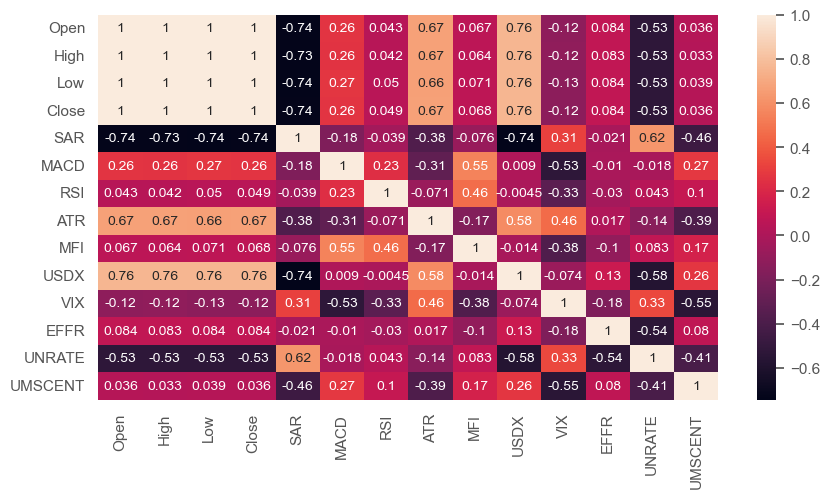

In [5]:
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
plt.show()

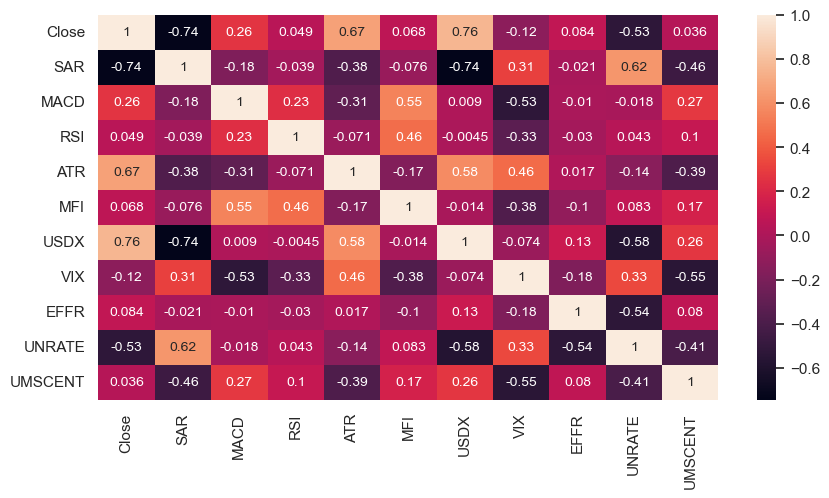

In [6]:
data = data.iloc[:,3:]
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
plt.show()

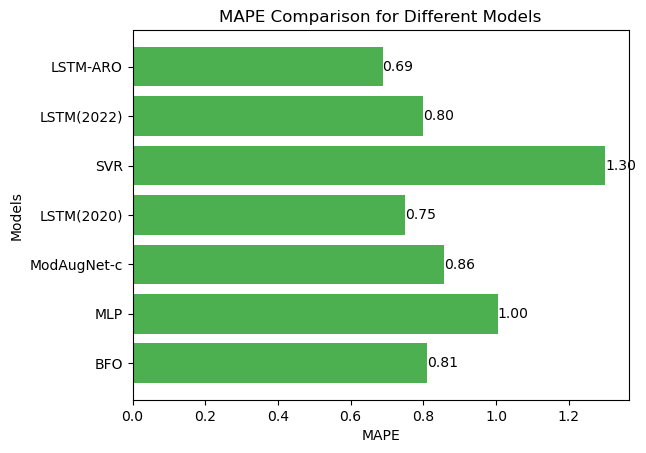

In [7]:
import matplotlib.pyplot as plt
models = ["BFO", "MLP", "ModAugNet-c", "LSTM(2020)", "SVR", "LSTM(2022)", "LSTM-ARO"]
mape_values = [0.8108, 1.0049, 0.8568, 0.75, 1.30, 0.7989, 0.6879]

plt.barh(models, mape_values, color='#4CAF50')

plt.xlabel('MAPE')
plt.ylabel('Models')
plt.title('MAPE Comparison for Different Models')

for index, value in enumerate(mape_values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.show()

In [6]:
import matplotlib.pyplot as plt
models = ["RNN (Single Layer)", "LSTM (Single Layer)", "LSTM (Multi Layer)", "LSTM (Single Layer)", "LSTM-ARO (Single Layer)"]
rmse_values = [48.261807, 50.319978, 61.090335, 61.095979, 40.048673]

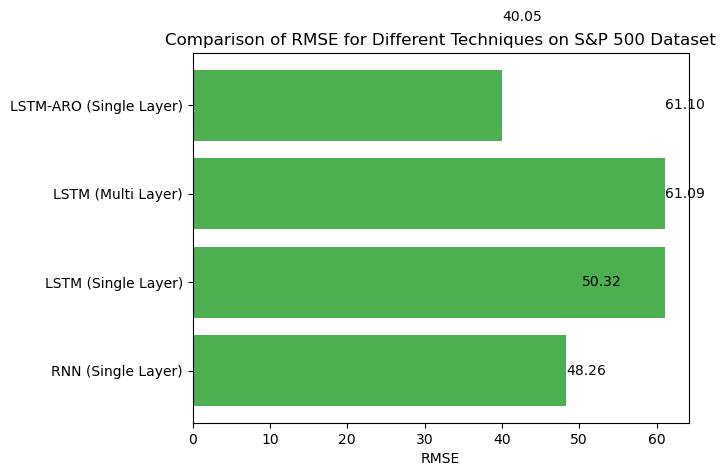

In [7]:
import matplotlib.pyplot as plt

# Assuming models_data is a DataFrame with 'Technique' and 'RMSE' columns

plt.barh(models, rmse_values, color='#4CAF50')
plt.xlabel('RMSE')
plt.title('Comparison of RMSE for Different Techniques on S&P 500 Dataset')

for index, value in enumerate(rmse_values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
models_data = pd.read_excel("D:\Final Year Project\Results\VariousModelResultsRMSE.xlsx")
models_data.head()

,Technique,Dataset,RMSE,Unnamed: 3,Unnamed: 4
0,Linear Regression,S&P 500,1102.740792,NaN,NaN
1,RNN ( Single Layer ),S&P 500,48.261807,NaN,NaN
2,LSTM ( Single Layer ),S&P 500,50.319978,NaN,NaN
3,LSTM ( Multi Layer ),S&P 500,61.090335,NaN,NaN
4,Bi-LSTM,S&P 500,61.095979,NaN,NaN


In [15]:
models_data = models_data.drop(["Dataset","Unnamed: 3","Unnamed: 4"],axis=1)
models_data = models_data[1:]

In [16]:
models_data

,Technique,RMSE
1,RNN ( Single Layer ),48.261807
2,LSTM ( Single Layer ),50.319978
3,LSTM ( Multi Layer ),61.090335
4,Bi-LSTM,61.095979
5,LSTM-ARO,40.048673
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,Models,Alpha
10,Linear,NaN


In [17]:
models_data = models_data[:6]
models_data

,Technique,RMSE
1,RNN ( Single Layer ),48.261807
2,LSTM ( Single Layer ),50.319978
3,LSTM ( Multi Layer ),61.090335
4,Bi-LSTM,61.095979
5,LSTM-ARO,40.048673
6,NaN,NaN


In [19]:
models_data = models_data[:5]
models_data

,Technique,RMSE
1,RNN ( Single Layer ),48.261807
2,LSTM ( Single Layer ),50.319978
3,LSTM ( Multi Layer ),61.090335
4,Bi-LSTM,61.095979
5,LSTM-ARO,40.048673


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


data = {
    'methods' : ['Linear','Ridge','Lasso','Polynomial','Elastic Net'],
    'rmse' : [1102.740792,992.4558393,649.0209683,1055.9643743,649.0209683]
}

data = pd.DataFrame(data)
print(data['methods'])

0         Linear
1          Ridge
2          Lasso
3     Polynomial
4    Elastic Net
Name: methods, dtype: object


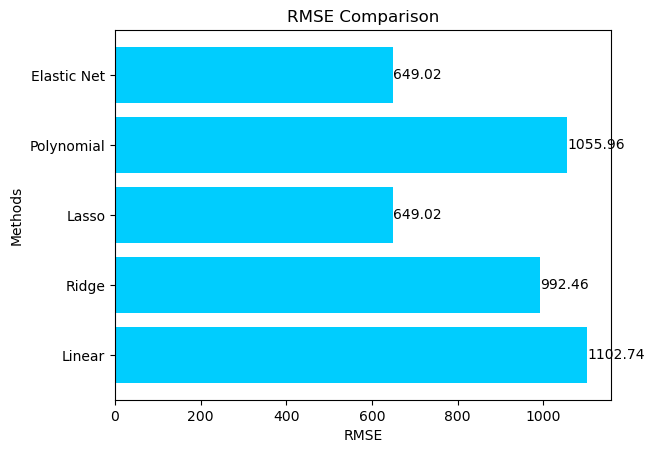

In [3]:
plt.barh(data['methods'], data['rmse'], color='#00CDFE')

for index, value in enumerate(data['rmse']):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center')
    
plt.xlabel('RMSE')
plt.ylabel('Methods')
plt.title('RMSE Comparison')
plt.show()